Make reaction profile

In [8]:
def plotProfile(energySets, filename, curviness=False, pointType='bar', desaturateFactor=1.2, desaturateCurve=False, labels=False, dashed=False):
    import matplotlib.pyplot as plt
    import matplotlib.colors as mpc
    import numpy as np
    import pandas as pd
    from matplotlib.path import Path
    from matplotlib.patches import PathPatch
    from scipy.signal import argrelextrema

    # Define the coordinates for plotting
    def generate_coordinates(energies):
        x_coords = []
        y_coords = []
        i = 0
        while i < len(energies):
            x_coords.append(i)
            y_coords.append(energies[i])
            
            j = i + 1
            # Check for consecutive identical energies
            while j < len(energies) and energies[j] == energies[i]:
                j += 1
            
            # If there are multiple identical values, adjust x-coordinates
            if j - i > 1:
                midpoint = (x_coords[-1] + j - 1) / 2
                x_coords[-1] = midpoint  # Assign midpoint to the first identical energy
                y_coords[-1] = energies[i]  # Assign the same energy
                
                # Only add the midpoint once for the last of the identical energies
                x_coords.append(midpoint)
                y_coords.append(energies[i])
            
            i = j  # Skip over the identical values
        return x_coords, y_coords

    # Generate coordinates for all energy sets
    energySets = [generate_coordinates(energies) for energies in energySets]
    
    # Set the length of the horizontal bars for data points
    barLength = 0.3
    barWidth = 2.5

    # Set the buffer space between bars and labels, get the bufferSpace as a percentage of the range of the data
    # Calculate bufferSpace as a percentage of the range of the data
    all_energies = [energy for xCoords, energies in energySets for energy in energies if not np.isnan(energy)]
    bufferSpace = 0.025 * (max(all_energies) - min(all_energies))
    print(bufferSpace)
    
    # set buffer range for label spacing
    bufferRange = 1.0

    # Control curviness
    if not curviness:
        curviness = 0.42

    curveWidth = 2.0

    # Define color definitions for each profile
    colors = ['darkcyan', 'maroon', 'midnightblue', 'darkmagenta', 'darkgreen', 'saddlebrown']
    colors = colors[:len(energySets)]
    colors.reverse()

    def desaturate(originalColor, factor):
        # Convert RGB to HLS
        import colorsys
        rgb = mpc.to_rgb(originalColor)
        hls = colorsys.rgb_to_hls(*rgb)
        hls_new = (hls[0], 1 - (0.4 * factor), 0.3 * factor)
        rgb_new = colorsys.hls_to_rgb(*hls_new)
        return rgb_new
    
    colorsLight = [desaturate(color, factor=desaturateFactor) for color in colors]

    # Reverse the order of the energy sets to plot the 1st set last (so on the top layer of the plot)
    energySets.reverse()

    # dashed numbers correspond to the index of the energySets list before reversing it...
    dashed = [len(energySets) - i - 1 for i in dashed]

    # Set to keep track of already labeled coordinates
    labeledCoords = set()

    # Create Bezier curves to connect the points and form each reaction profile
    for i, (xCoords, energies) in enumerate(energySets):
        if i in dashed:
            dash_capstyle = 'round'
            linestyle = 'dashed'
        else:
            linestyle = 'solid'
        vertices = []
        codes = [Path.MOVETO]
        for j in range(len(energies) - 1):
            if not np.isnan(energies[j]) and not np.isnan(energies[j + 1]):
                vertices.append([xCoords[j], energies[j]])
                vertices.append([xCoords[j] + curviness * (xCoords[j + 1] - xCoords[j]), energies[j]])
                vertices.append([xCoords[j + 1] - curviness * (xCoords[j + 1] - xCoords[j]), energies[j + 1]])
                vertices.append([xCoords[j + 1], energies[j + 1]])
                if j != len(energies) - 2:
                    codes.extend([Path.CURVE4, Path.CURVE4, Path.CURVE4, Path.MOVETO])
                else:
                    codes.extend([Path.CURVE4, Path.CURVE4, Path.CURVE4])
        
        # Create the Path and PathPatch for the Bezier curve
        path = Path(vertices, codes)
        if desaturateCurve:
            patch = PathPatch(path, facecolor='none', edgecolor=colorsLight[i], linewidth=curveWidth, linestyle=linestyle)
        else: 
            patch = PathPatch(path, facecolor='none', edgecolor=colors[i], linewidth=curveWidth, linestyle=linestyle)
        plt.gca().add_patch(patch)

    if pointType == 'bar':
        # Plot the individual data points as disconnected horizontal bars (black color) for each curve
        for i, (xCoords, energies) in enumerate(energySets):
            for j, energy in enumerate(energies):
                if not np.isnan(energy):
                    plt.plot([xCoords[j] - barLength / 2, xCoords[j] + barLength / 2], [energy, energy], color='black', linewidth=barWidth)
    elif pointType == 'dot':
        # Plot the data points as dots on the curve 
        for i, (xCoords, energies) in enumerate(energySets):
            for j, energy in enumerate(energies):
                if not np.isnan(energy):
                    plt.plot(xCoords[j], energy, 'o', markersize=5, color=colors[i])

    ### Calculate label positions and alignments ### 
    for i, (xCoords, energies) in enumerate(energySets):
        for j, energy in enumerate(energies):
            if not np.isnan(energy):
                local_maxima = argrelextrema(np.array(energies), np.greater)[0]

                # Add label only if the coordinates are not already labeled
                coordKey = (tuple(xCoords[j]) if isinstance(xCoords[j], list) else xCoords[j], tuple(energy) if isinstance(energy, list) else energy)
                if coordKey not in labeledCoords:
                    is_local_maxima = j in local_maxima

                    # local_maxima = argrelextrema(np.array(energies), np.greater)[0]
                    label_above = any(
                        abs(label_pos[1] - energy) <= bufferRange for label_pos in labeledCoords if label_pos[1] > energy
                    )
                    label_below = any(
                        abs(label_pos[1] - energy) <= bufferRange for label_pos in labeledCoords if label_pos[1] < energy
                    )

                    # ensure that the position is based on the energy values to either side wiht a maximum or minimum

                    # Adjust label position based on local extrema and existing labels
                    label_pos_updated = None  # Initialize a variable to store the updated label position
                    if is_local_maxima:
                        if label_above:
                            label_pos_updated = energy - bufferSpace
                            verticalalignment = 'top'
                            text = bufferSpace
                        elif label_below:
                            label_pos_updated = energy + bufferSpace
                            verticalalignment = 'bottom'
                            text = -bufferSpace
                        else:
                            label_pos_updated = energy + bufferSpace
                            verticalalignment = 'bottom'
                            text = bufferSpace
                    else:
                        label_pos_updated = energy - bufferSpace
                        verticalalignment = 'top'
                        text = bufferSpace
                        # if label_above:
                        #     label_pos_updated = energy - bufferSpace
                        #     verticalalignment = 'top'
                        #     text = bufferSpace
                        # elif label_below:
                        #     label_pos_updated = energy + bufferSpace
                        #     verticalalignment = 'bottom'
                        #     text = -bufferSpace
                        # else:
                        #     label_pos_updated = energy - bufferSpace
                        #     verticalalignment = 'top'
                        #     text = -bufferSpace
                    # if is_local_maxima:  # Prefer placing labels above for local maxima
                    #     if not label_above:
                    #         label_pos_updated = energy + bufferSpace
                    #         verticalalignment = 'bottom'
                    #         text = bufferSpace
                    #     else:  # If above is occupied, place below
                    #         label_pos_updated = energy - bufferSpace
                    #         verticalalignment = 'top'
                    #         text = -bufferSpace
                    # else:  # For non-maxima points
                    #     if not label_below:
                    #         label_pos_updated = energy - bufferSpace
                    #         verticalalignment = 'top'
                    #         text = -bufferSpace
                    #     else:  # If below is occupied, place above
                    #         label_pos_updated = energy + bufferSpace
                    #         verticalalignment = 'bottom'
                    #         text = bufferSpace

                    # if label_pos_updated is not None:
                        # Add the label to the set of labeled coordinates
                    labeledCoords.add((xCoords[j], energy, label_pos_updated))  # Pack all label info into a tuple

    if labels:
        ### Plot the labels using the calculated positions and alignments ###
        for coordKey in labeledCoords:
            x, energy, label_pos = coordKey
            plt.annotate(str(f"{energy:.1f}").replace('-', '−'), xy=(x, label_pos),
                        xytext=(0, text), textcoords='offset points', ha='center', va=verticalalignment,
                        fontsize=10)

    # Set y-axis label
    plt.ylabel(r'$\Delta G \text{ (kcal/mol)}$', fontsize=10)

    # Hide the x-axis and ticks
    ax = plt.gca()
    ax.xaxis.set_visible(False)
    ax.set_xticks([])
    ax.yaxis.set_visible(False)
    ax.set_yticks([])

    # Remove the box around the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Set size of the plot
    plt.gcf().set_size_inches(8, 4)

    # Save the plot as a file
    plt.savefig(f'{filename}.eps', format='eps', dpi=600, bbox_inches='tight')

    # Display the plot
    plt.show()


0.8802500000000001


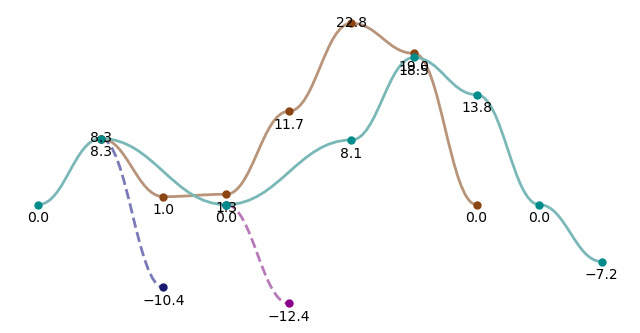

In [9]:
import numpy as np

energySets = [
    [ 0.00, 8.31, 0.00, 0.00, 0.00, 8.13, 18.5, 13.83, 0.00, -7.17 ],
    [ np.nan, 8.31, 1.0, 1.3, 11.73, 22.81, 19.02, 0.00, ],
    [ np.nan, 8.31, -10.4 ],
    [ np.nan, np.nan, np.nan, 0.0, -12.4],
    # [ 0.0, -8.0, np.nan, np.nan, 8.1, -3.0 ],
    ]

# if the index is the same as the next one, it will be plotted halfway between the points on the reaction coordinate and then skip the next point
# dashed takes a list of indices of the energySets to make dashed 
# need to use np.nan to skip a point 

plotProfile(energySets, filename='reaction_profile', curviness=0.42, pointType='dot', desaturateFactor=1.0, desaturateCurve=True, labels=True, dashed=[2,3] )

# pointType can be 'bar' or 'dot'
# desaturateFactor is the factor by which the color is desaturated (distinguish dot from the curve)
# labels are weird and I'll fix them later but if you post process the eps file then you can move them